In [ ]:
import os
import uuid
import warnings
from typing import List, TypedDict, Annotated

warnings.filterwarnings("ignore")

from IPython.display import Markdown


from pydantic import BaseModel, Field


from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    AIMessage,
    SystemMessage
)
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableConfig

from langchain_openai import ChatOpenAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter


from langchain_community.vectorstores.pgvector import PGVector

from tqdm import tqdm
from langgraph.graph import (
    StateGraph,
    START,
    END,
    MessagesState
)
from langgraph.graph.message import add_messages
from langgraph.store.base import BaseStore


from dotenv import load_dotenv
load_dotenv(dotenv_path=r"C:\Users\hasee\Desktop\Legal Chatbot\.env")

True

In [ ]:
api_key = os.environ.get("GOOGLE_API_KEY")
CONNECTION_STRING = os.environ.get("CONNECTION_STRING","")
SUPERBASE_SERVICE_ROLE_KEY = os.environ.get("SUPERBASE_SERVICE_ROLE_KEY","")
SUPABASE_URL = os.environ.get("SUPABASE_URL","")
COLLECTION_NAME = "chunks" # table in superbase

In [ ]:
from sqlalchemy import create_engine
#Connect --> methood = session pooler


engine = create_engine(CONNECTION_STRING)
with engine.connect() as conn:
    print("Connected to Supabase Postgres")


Connected to Supabase Postgres


In [ ]:
# chatting llm
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)


# RAG Tool 

In [72]:
PROMPT_TEMPLATE = """
You are a legal AI assistant for Pakistan.

Answer the question using ONLY the context below.
If possible, cite sections or articles.
If the answer is not in the context, say so clearly.

Context:
{context}

Question:
{query}

Answer:"""

In [73]:
from langchain_core.documents import Document
from langchain_community.document_loaders import DirectoryLoader
class LegalRAG(TypedDict):
    documents_path:str
    document:list[Document]
    chunks:list[Document] 
    vectorstore:PGVector | None
    collection_name:str
    retrieved_docs:list[Document]
    context: str 
    answer:str
    vectorstore_path:str
    messages: Annotated[list[BaseMessage], add_messages]





In [ ]:
#========================== Document Loader
def document_loader(state:LegalRAG):
    path = os.path.abspath(state["documents_path"])
    # if it is file
    if os.path.isfile(path):
        loader = PyPDFLoader(path)
        document = loader.load()

    #if it is directery
    elif os.path.isdir(path):
        loader = DirectoryLoader(
            path=path,
            glob="*.pdf",
            loader_cls = PyPDFLoader
        )
        document = loader.load()
    state["document"] = document
    return state

# ==================== Text Splitter

def text_splitter(state:LegalRAG):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
        )
    chunks = splitter.split_documents(state["document"])
    for i, doc in enumerate(chunks):
        doc.metadata["doc_id"] = "constitution_001"
        doc.metadata["chunk_index"] = i
        doc.metadata["file_name"] = "constitution.pdf"

    print("Len of Chunks ",len(chunks))

    
    state["chunks"] = chunks
    return state

#======================================Creat Vector Store
# we can not store vector store directly in langgraph state

def create_vector_store(state:LegalRAG, batch_size: int = 20):
    
    vectorstore = PGVector(
        connection_string=CONNECTION_STRING,
        collection_name="qanoon",  # table name in Supabase
        embedding_function=EMBEDDER,
    )

    chunks = state["chunks"]

    # Batch upload 
    for i in tqdm(range(0, len(chunks), batch_size), desc="Uploading chunks"):
        batch = chunks[i:i+batch_size]
        # Generate embeddings for this batch
        embeddings = EMBEDDER.embed_documents([c.page_content for c in batch])
        # add batch to vector store
        vectorstore.add_embeddings(batch, embeddings)

    state["vectorstore"] = vectorstore
    print(f" Uploaded {len(chunks)} chunks to Supabase")
    return state


# ========================== Load Vecotr Store
def load_vector_store(state:LegalRAG):
    vectorstore = PGVector(
        connection_string=CONNECTION_STRING,
        collection_name="qanoon", # table name in superbase
        embedding_function=EMBEDDER,
        )

    state["vectorstore"] = vectorstore
    return state



# ============================== Retriever
def retriever(state:LegalRAG):     
    vectorstore = PGVector(
        connection_string=CONNECTION_STRING,
        collection_name="qanoon", # table name in superbase
        embedding_function=EMBEDDER,
    )
    retriever = vectorstore.as_retriever(
            search_type="similarity",
            search_kwargs={"k": 5}
        )
    human_messages = [
            m for m in state.get("messages",[]) if isinstance(m,HumanMessage)
        ]
    if not human_messages:
        raise ValueError("No humman message found in state for retrival")
    query = human_messages[-1].content

    retrieved_docs = retriever.invoke(query)
    state["retrieved_docs"] = retrieved_docs
    return state



#=============================== Context Builder
def context_builder(state:LegalRAG):
        retrieved_docs = state.get("retrieved_docs","")

        context = "\n\n".join(
            f"[Source: {doc.metadata.get('file_name', 'Unknown')} "
            f"- Page {doc.metadata.get('page', 'N/A')}]\n"
            f"{doc.page_content}"
            for doc in retrieved_docs
                    )
        state["context"] = context
        return state





#================= RAG Agent =========
def agent_response(state:LegalRAG):
    context = state.get("context","")

    human_messages = [
        m for m in state.get("messages",[]) if isinstance(m,HumanMessage)
    ]
    if not human_messages:
        raise ValueError("No humman message found in state for retrival")
    
    query = human_messages[-1].content
    
    formateed_prompt = PROMPT_TEMPLATE.format(
        context=context,
        query=query
    )

    response = llm.invoke(formateed_prompt)

    # Save to state instead of external memory
    state.setdefault("messages", [])
    state["messages"].append(HumanMessage(content=query))
    state["messages"].append(AIMessage(content=response.content))
    state["answer"] = response.content
    return state
    
#================= Conditional Node

def conditional(state:LegalRAG):
    # Check if we have a documents_path to process
    if state.get("documents_path"):
        return "create_vectorstore"
    else:
        return "load_vectorstore"

In [ ]:
from superbase import create_client

from supabase import create_client
from typing import List
import numpy as np


#========================== Document Loader
def document_loader(state:LegalRAG):
    path = os.path.abspath(state["documents_path"])
    # if it is file
    if os.path.isfile(path):
        loader = PyPDFLoader(path)
        document = loader.load()

    #if it is directery
    elif os.path.isdir(path):
        loader = DirectoryLoader(
            path=path,
            glob="*.pdf",
            loader_cls = PyPDFLoader
        )
        document = loader.load()
    state["document"] = document
    return state

# ==================== Text Splitter

def text_splitter(state:LegalRAG):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
        )
    chunks = splitter.split_documents(state["document"])
    for i, doc in enumerate(chunks):
        doc.metadata["doc_id"] = "constitution_001"
        doc.metadata["chunk_index"] = i
        doc.metadata["file_name"] = "constitution.pdf"

    print("Len of Chunks ",len(chunks))

    
    state["chunks"] = chunks
    return state


class SupabaseRAGManager:
    def __init__(self, url: str, key: str, embedder):
        self.client = create_client(url, key)
        self.embedder = embedder
    
    def add_document(self, doc_id: str, file_name: str, user_id: str = None):
        """Add document metadata"""
        return self.client.table("documents").insert({
            "doc_id": doc_id,
            "file_name": file_name,
            "user_id": user_id,
            "metadata": {}
        }).execute()
    
    def add_chunks_batch(self, chunks: List[Document], batch_size: int = 100):
        """Batch insert chunks with embeddings"""
        for i in range(0, len(chunks), batch_size):
            batch = chunks[i:i + batch_size]
            
            # Generate embeddings in batch (more efficient)
            texts = [chunk.page_content for chunk in batch]
            embeddings = self.embedder.embed_documents(texts)
            
            # Prepare rows
            rows = []
            for chunk, embedding in zip(batch, embeddings):
                rows.append({
                    "doc_id": chunk.metadata["doc_id"],
                    "chunk_index": chunk.metadata["chunk_index"],
                    "content": chunk.page_content,
                    "embedding": embedding,
                    "metadata": chunk.metadata
                })
            
            # Batch insert
            try:
                self.client.table("chunks").insert(rows).execute()
                print(f"Inserted batch {i//batch_size + 1}: {len(rows)} chunks")
            except Exception as e:
                print(f"Error inserting batch: {e}")
                # Insert individually if batch Fail
                for row in rows:
                    try:
                        self.client.table("chunks").insert(row).execute()
                    except Exception as e2:
                        print(f"Failed to insert chunk: {e2}")
    

    def search_similar(self, query: str, top_k: int = 5, doc_id: str = None):
        """Semantic search using Supabase function"""
        query_embedding = self.embedder.embed_query(query)
        
        # Use the match_chunks function from your SQL
        result = self.client.rpc(
            'match_chunks',
            {
                'query_embedding': query_embedding,
                'match_count': top_k,
                'filter': {'doc_id': doc_id} if doc_id else {}
            }
        ).execute()
        
        return result.data
    
    def delete_document(self, doc_id: str):
        """Delete document and all its chunks (cascade)"""
        return self.client.table("documents").delete().eq("doc_id", doc_id).execute()


# Initialize the manager
rag_manager = SupabaseRAGManager(
    url=SUPABASE_URL,
    key=SUPERBASE_SERVICE_ROLE_KEY,
    embedder=EMBEDDER
)


# Update your nodes
def create_vector_store(state: LegalRAG):
    """Create vectorstore with batch insertion"""
    doc_id = state["chunks"][0].metadata["doc_id"]
    file_name = state["chunks"][0].metadata["file_name"]
    
    # Add document metadata
    rag_manager.add_document(doc_id, file_name)
    
    # Batch insert chunks
    rag_manager.add_chunks_batch(state["chunks"], batch_size=100)
    
    print(f"Uploaded {len(state['chunks'])} chunks to Supabase")
    return state



def retriever(state: LegalRAG):
    """Retrieve using Supabase RPC function"""
    human_messages = [
        m for m in state.get("messages", []) if isinstance(m, HumanMessage)
    ]
    if not human_messages:
        raise ValueError("No human message found")
    
    query = human_messages[-1].content
    
    # Use the custom search function
    results = rag_manager.search_similar(query, top_k=5)
    
    # Convert to Document objects
    retrieved_docs = [
        Document(
            page_content=r["content"],
            metadata=r["metadata"]
        )
        for r in results
    ]
    
    state["retrieved_docs"] = retrieved_docs
    return state





#=============================== Context Builder
def context_builder(state:LegalRAG):
        retrieved_docs = state.get("retrieved_docs","")

        context = "\n\n".join(
            f"[Source: {doc.metadata.get('file_name', 'Unknown')} "
            f"- Page {doc.metadata.get('page', 'N/A')}]\n"
            f"{doc.page_content}"
            for doc in retrieved_docs
                    )
        state["context"] = context
        return state





#================= RAG Agent =========
def agent_response(state:LegalRAG):
    context = state.get("context","")

    human_messages = [
        m for m in state.get("messages",[]) if isinstance(m,HumanMessage)
    ]
    if not human_messages:
        raise ValueError("No humman message found in state for retrival")
    
    query = human_messages[-1].content
    
    formateed_prompt = PROMPT_TEMPLATE.format(
        context=context,
        query=query
    )

    response = llm.invoke(formateed_prompt)

    # Save to state instead of external memory
    state.setdefault("messages", [])
    state["messages"].append(HumanMessage(content=query))
    state["messages"].append(AIMessage(content=response.content))
    state["answer"] = response.content
    return state
    
#================= Conditional Node

def conditional(state:LegalRAG):
    # Check if we have a documents_path to process
    if state.get("documents_path"):
        return "create_vectorstore"
    else:
        return "load_vectorstore"

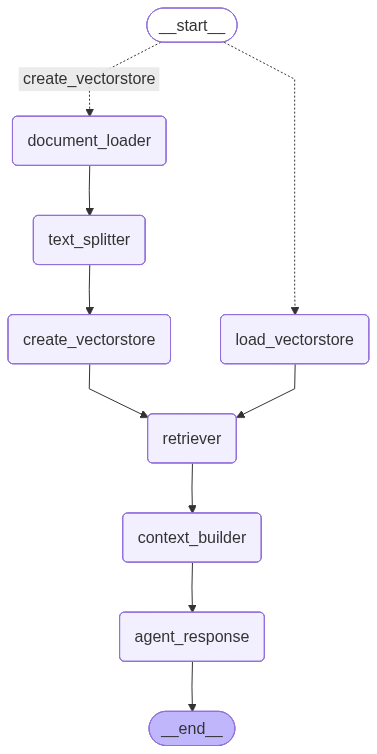

In [75]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(LegalRAG)

# nodes
workflow.add_node("document_loader", document_loader)
workflow.add_node("text_splitter", text_splitter)
workflow.add_node("create_vectorstore", create_vector_store)
workflow.add_node("load_vectorstore", load_vector_store)
workflow.add_node("retriever", retriever)
workflow.add_node("context_builder", context_builder)
workflow.add_node("agent_response", agent_response)

# edges
workflow.add_conditional_edges(
                    START,
                    conditional,
                {
                    "create_vectorstore": "document_loader",
                    "load_vectorstore": "load_vectorstore"
                })

# if new vector store
workflow.add_edge("document_loader", "text_splitter")
workflow.add_edge("text_splitter","create_vectorstore")
workflow.add_edge("create_vectorstore", "retriever")
workflow.add_edge("load_vectorstore", "retriever")

# if existing vectorstore
workflow.add_edge("load_vectorstore","retriever")

workflow.add_edge("retriever", "context_builder")
workflow.add_edge("context_builder", "agent_response")
workflow.add_edge("agent_response", END)


app = workflow.compile()
app

In [76]:
initial_state = {
    "documents_path":"../data/Constitution and law/constitution.pdf",  # ✅ Correct key
    "messages": [HumanMessage(content="summary of the document")]
}

result = app.invoke(initial_state)

Len of Chunks  638


GoogleGenerativeAIError: Error embedding content (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/embed_content_free_tier_requests, limit: 100, model: gemini-embedding-1.0\nPlease retry in 50.535521607s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/embed_content_free_tier_requests', 'quotaId': 'EmbedContentRequestsPerMinutePerUserPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-embedding-1.0'}, 'quotaValue': '100'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '50s'}]}}

In [62]:
Markdown(result["answer"])

The context provided does not contain any specific document or details to summarize. Therefore, I cannot provide a summary. Please provide the document or additional information for me to assist you.

# Using Load Vector store

In [ ]:
initial_state = {
    "messages": [HumanMessage(content="summary of the document")]
}

result2 = app.invoke(initial_state)

C:\Users\hasee\AppData\Local\Temp\ipykernel_9200\1824446649.py:55: LangChainPendingDeprecationWarning: Please use JSONB instead of JSON for metadata. This change will allow for more efficient querying that involves filtering based on metadata. Please note that filtering operators have been changed when using JSONB metadata to be prefixed with a $ sign to avoid name collisions with columns. If you're using an existing database, you will need to create a db migration for your metadata column to be JSONB and update your queries to use the new operators. 
  vectorstore = PGVector(
C:\Users\hasee\AppData\Local\Temp\ipykernel_9200\1824446649.py:68: LangChainPendingDeprecationWarning: Please use JSONB instead of JSON for metadata. This change will allow for more efficient querying that involves filtering based on metadata. Please note that filtering operators have been changed when using JSONB metadata to be prefixed with a $ sign to avoid name collisions with columns. If you're using an exis

In [35]:
result2["answer"]

'The document is the Constitution of the Islamic Republic of Pakistan. It establishes Pakistan as a federal republic with Islam as the state religion. The Constitution outlines the structure of the national government and specifies the rights and duties of its citizens. It also provides for the establishment of the federal judiciary, the Supreme Court, and the High Courts. The Constitution guarantees fundamental rights, including equality of status, of opportunity and before law, social, economic and political justice, and freedom of thought, expression, belief, faith, worship and association, subject to law and public morality. It also provides for the right to fair trial and due process, protection of property rights, and protection against retrospective punishment. The Constitution also outlines the powers and responsibilities of the President and the Prime Minister.'